# Logistic Regression on Titanic dataset from Kaggle

### Table of Contents
* [The Data](#data)
* [Logistic Regression Functions](#logisticregression)
* [Learning Curves](#learningcurves)
* [Feature Engineering](#featureengineering)

In [62]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import math
print("All packages imported successfully")

All packages imported successfully


In [63]:
#increase the size of the plot and set style
plt.rcParams['figure.figsize']=(12,6)

# Read in data <a class="anchor" id="data"></a>

In [64]:
# Read in the titanic data to a pandas dataframe
filepath = "./data/train.csv"
titanic = pd.read_csv(filepath)
titanic.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [65]:
# How many nulls do we have?
titanic.isna().mean()

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

Age is ~20% null, and cabin is around 80% null

I wont be using Cabin at first, so for now I will just drop the rows where age is missing so I can still run that column through the algorithm

In [66]:
titanic = titanic.dropna(subset=['Age'])
titanic.isna().mean()

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.000000
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.740896
Embarked       0.002801
dtype: float64

Kaggle withheld some data for testing and this is located in a seperate csv file. Testing data only contains the features and I have to submit my predictions to Kaggle to score the final model.

In [67]:
# Read in the titanic testing data to a pandas dataframe
filepath = "./data/test.csv"
titanicTest = pd.read_csv(filepath)
titanicTest.sample(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
66,958,3,"Burns, Miss. Mary Delia",female,18.0,0,0,330963,7.8792,NaN,Q
121,1013,3,"Kiernan, Mr. John",male,NaN,1,0,367227,7.7500,NaN,Q
84,976,2,"Lamb, Mr. John Joseph",male,NaN,0,0,240261,10.7083,NaN,Q
184,1076,1,"Douglas, Mrs. Frederick Charles (Mary Helene B...",female,27.0,1,1,PC 17558,247.5208,B58 B60,C
408,1300,3,"Riordan, Miss. Johanna Hannah""""",female,NaN,0,0,334915,7.7208,NaN,Q


In [68]:
titanic.Survived.mean()

0.4061624649859944

Since ~40% surivived, I would say the data is pretty well balanced and I'm not going to worry about stratifying my train/validation split.

Use 75% of the data to train, reserve 25% for validation

In [95]:
indexToSplitOn = int(len(titanic)*.75)
train = titanic.loc[0:indexToSplitOn]
validate = titanic.loc[indexToSplitOn+1:]

In [96]:
print("Percentage of people who survived in training data: {:.2%}".format(train.Survived.mean()))
print("Percentage of people who survived in validation data: {:.2%}".format(validate.Survived.mean()))

Percentage of people who survived in training data: 40.24%
Percentage of people who survived in validation data: 41.18%


There are pretty much an equal number of survivors in the training and validation data sets 👍

In [97]:
# first build model on only these feature, include other features and perform feature engineering later
initialFeatures = ['Age', 'SibSp', 'Parch', 'Fare']

# Seperate the features from target variable
x_train = train[initialFeatures]
y_train = train.Survived

x_validate = validate[initialFeatures]
y_validate = validate.Survived

### Normalize the features
Note: the mean & standard deviation for feature normalization are learned parameters so best practice is to calculate these only on the training data

In [98]:
mu = x_train.mean()
sigma = x_train.std()

x_train_norm_init = (x_train-mu)/sigma
x_validate_norm_init = (x_validate-mu)/sigma

### Add intercept values to feature matrix

In [99]:
x_train_norm_init.insert(0,"intercept", 1, True)
x_validate_norm_init.insert(0,"intercept", 1, True)

# Logistic Regression Helper Functions <a class="anchor" id="logisticregression"></a>

The hypothese function of logistic regression is: $h_{\theta}(x) = S(\theta^{T}x)$ where S is the sigmoid function:
$S(z) = \frac{1}{1+e^{-z}}$

In [100]:
def h(X, theta):
    '''take in a feature matrix x and parameters theta as numpy arrays and compute
    the hypothesis values'''
    
    arr = sigmoid(np.dot(X,theta))
    #print(arr)
    arr[arr == 1] = 0.99999999999999
    #print(arr)
    
    return arr

In [101]:
def sigmoid(z):
    '''Take in a scalar or numpy array and returns the same object
    after performing a sigmoid transformation'''
    
    return 1/(1+np.exp(-z))

For Logistic Regression, the cost function J with regularization is defined as 
$J(\theta ) 
    = -[\frac{1}{m} \sum_{i=1}^m 
    (y^{(i)} log(h_\theta (x^i)) 
    + (1 – y^{(i)}) log(1-h_\theta (x^{(i)}))] 
+ \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_{j}^{2}$

In [102]:
# Define cost function for logistic regression
def costFunction(X, y, theta, L):
    '''Take in a parameter vector theta as numpy array, 
        feature matrix X as numpy array, 
        target vector y as numpy array,
        and regularization term lambda and return the cost''' 
    
    m = len(y)

    #Since the cost function is so long, I broke it into part, second, and regularization parts
    firstPart = np.dot(-y.T, np.log(h(X, theta)))
    
    #print(f"firstPart: {firstPart}")

    secondPart = np.dot(1-y.T, np.log(1-h(X, theta)))
    
    #print(f"secondPart: {secondPart}")

    regulizationTerm = L/(2*m) * np.sum(np.square(theta[1:]))
    #print(f"regulizationTerm: {regulizationTerm}")
    
    J = 1/m * (firstPart - secondPart) + regulizationTerm
    
    return J.flatten()

The gradient of the cost function J is $\frac{dJ(\theta)}{d\theta} = \frac{1}{m} \sum_{i=1}^{m}(h_\theta(x_i)-y_i) x_i + \frac{\lambda}{m}\theta$, however do not use regularization on the intercept parameter

In [103]:
def gradient(X, y, theta, L):
    '''Take in a parameter vector theta as numpy array, 
        feature matrix X as numpy array, 
        target vector y as numpy array,
        and regularization term lambda 
        and return the gradient'''
    m = len(y) #number of training examples

    grad = np.zeros(len(theta))
    grad[0] = 1/m*np.dot((h(X, theta)-y).T, X).T[0]
    grad[1:] = (1/m*np.dot((h(X, theta)-y).T, X).T + L/m*theta)[1:]
    
    return grad


Goal of gradient descent is to minimize cost J. Here is the algorithm:

Repeat $\theta_j:=\theta_j-\alpha\frac{\delta}{\delta \theta_j}J(\theta)$ for a defined number of iterations

In [104]:
# define gradient descent function
def gradientDescent(X, y, theta, L, a, s=10000):
    '''Take in a feature matrix X, target vector y, 
    parameters theta, learing rate alpha, and regularization 
    parameter lambda, and return the tuned parameters 
    theta, cost values J, and minimized cost value J
    '''
    
    m = len(y) #number of training examples
    
    J_history = pd.DataFrame(columns=['J']) #empty dataframe we will append costs to


    for i in range(s):
        # Perform a single gradient step on the parameter vector theta
        theta = theta - a * gradient(X, y, theta, L)   
        
        #calculate cost J with new parameters theta and append to J_history
        J = costFunction(X, y, theta, L)
        J_history = J_history.append({'J': J}, ignore_index=True)
        
        # if there is not signifcant improvement of the cost function then break the loop
        if abs(J_history.J.tail(2).diff().iloc[-1]) < 10e-6:
            break
        
    return [theta, J_history, J

In [105]:
theta_tuned_1, J_history_1, J_1 = gradientDescent(X=x_train_norm_init.to_numpy(), 
                                      y=y_train.to_numpy(), 
                                      theta=np.array([10,10,10,10,10]),
                                      L=5, a=4)

In [106]:
print(f'Best cost using Age, Fare, #Parents, & #Siblings: {J_1}')

Best cost using Age, Fare, #Parents, & #Siblings: [0.63601225]


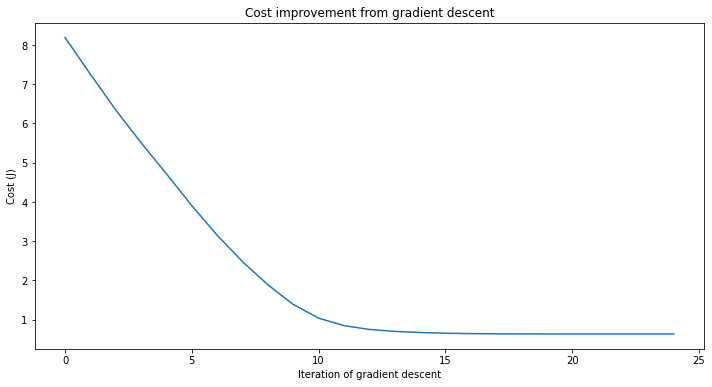

In [19]:
plt.plot(J_history)
plt.xlabel('Iteration of gradient descent')
plt.ylabel('Cost (J)')
plt.title('Cost improvement from gradient descent')
plt.show()

In [20]:
theta_tuned

array([-0.39579164, -0.3183789 , -0.31346063,  0.13778799,  0.54629817])

# Learning Curves <a class="anchor" id="learningcurves"></a>

In [107]:
# Choose some value for the learning rate alpha 
alpha = 2

# Choose some value for the regularization parameter lambda
# recall, high lambda results in simple hypothesis which is less prone to overfitting
lambd = 2

# Ititialize parameter vector theta
theta_init = np.array([-0.39579164, -0.3183789 , -0.31346063,  0.13778799,  0.54629817])

# Convert pandas dataframes to numpy arrays 
x = x_train_norm_init.to_numpy()
y = y_train.to_numpy()

x_cv = x_validate_norm_init.to_numpy()
y_cv = y_validate.to_numpy()

optimizationLearningCurves = pd.DataFrame(columns=['Training Error', 'Validation Error'])
performanceLearningCurves = pd.DataFrame(columns=['Training Accuracy', 'Validation Accuracy'])

for i in range(2, len(x), 2):
    #print(i, end=', ')
    
    #Limit training set to only i observations
    xLC = x[0:i]
    yLC = y[0:i]

    tuned_theta, jhist, JTrain = gradientDescent(xLC, yLC, theta_init, lambd, alpha)

    #Use tuned parameters to calculate cost of cross validation data
    JValidation = costFunction(x_cv, y_cv, tuned_theta, lambd)
    
    #Store J-Train and J-Cross-Validation
    optimizationLearningCurves = optimizationLearningCurves.append(
        {'Training Error':JTrain,'Validation Error':JValidation},ignore_index=True)
    
    #Store prediction accuracy scores
    trainingScore = ((h(xLC, tuned_theta)>.5).astype(int)==yLC).mean()
    validationScore = ((h(x_cv, tuned_theta)>.5).astype(int)==y_cv).mean()
    performanceLearningCurves = performanceLearningCurves.append(
        {'Training Accuracy':trainingScore,'Validation Accuracy':validationScore},ignore_index=True)

/Users/mikewiggins/Documents/Machine-Learning-Projects.nosync/Titanic/ENVNAME/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/Users/mikewiggins/Documents/Machine-Learning-Projects.nosync/Titanic/ENVNAME/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


## Optimization Learning Curves

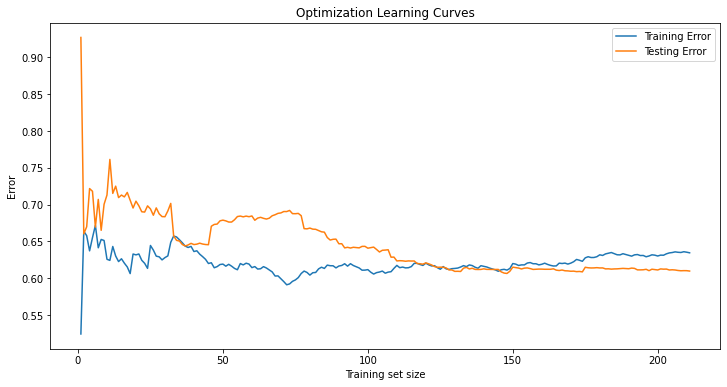

In [108]:
plt.plot(optimizationLearningCurves)
plt.xlabel('Training set size')
plt.ylabel('Error')
plt.title('Optimization Learning Curves')
plt.legend(['Training Error', 'Testing Error'])
plt.show()

## Performance Learning Curves

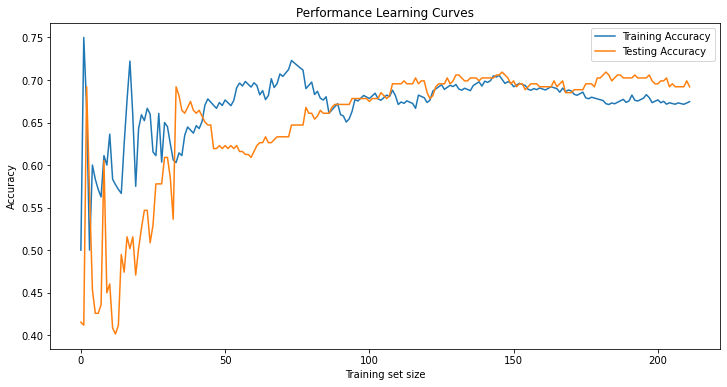

In [109]:
plt.plot(performanceLearningCurves)
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.title('Performance Learning Curves')
plt.legend(['Training Accuracy', 'Testing Accuracy'])
plt.show()

In [136]:
score = ((h(x_cv, tuned_theta)>.5).astype(int)==y_cv).mean()
print('Validation accuracy: {:.1%}'.format(score))

Validation accuracy: 69.2%


# Feature Engineering <a class="anchor" id="featureengineering"></a>

## Notes on string/categorical values
* Feature engineering (eg. replace the values with frequency)
* create dummy columns (this is good when you have a small number of unique values in the column
    *note: need to use drop.first=true so you dont have multicollinearity
* TFIDF (Doesnt really apply to this problem) 

I originally left out the categorical variables Class, Embarked, and Sex. I will perform one-hot encoding on those now and include them in my model! Hopefully the model will be able to perform better than 69.2% accuracy with these extra features. 

In [111]:
x_train_with_categoricals = x_train_norm_init
x_validate_with_categoricals = x_validate_norm_init

### One hot encode 'Sex'

In [112]:
titanic.Sex.value_counts()

male      453
female    261
Name: Sex, dtype: int64

In [113]:
# Use 'Sex' to create a new one-hot encoded feature "isMale" that is 1 if the passenger is male, 0 otherwise
# Note: Including a similar feature "isFemale" would be redundant with isMale and would cause multicollinearity
isMale = (titanic.Sex == 'male').astype(int)
x_train_with_categoricals['isMale'] = isMale.loc[0:indexToSplitOn]
x_validate_with_categoricals['isMale'] = isMale.loc[indexToSplitOn+1:]

### One hot encode 'Embarked'
Note: this variable signifies to port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

In [114]:
titanic.Embarked.value_counts()

S    554
C    130
Q     28
Name: Embarked, dtype: int64

In [115]:
Southampton = (titanic.Embarked == 'S').astype(int)
Queenstown = (titanic.Embarked == 'Q').astype(int)

x_train_with_categoricals['Southampton'] = Southampton.loc[0:indexToSplitOn]
x_validate_with_categoricals['Southampton'] = Southampton.loc[indexToSplitOn+1:]

x_train_with_categoricals['Queenstown'] = Queenstown.loc[0:indexToSplitOn]
x_validate_with_categoricals['Queenstown'] = Queenstown.loc[indexToSplitOn+1:]

### One hot encode Pclass
Note: although this field contains numeric values, I will treat it as categorical since it would be wrong to do math on the distinct values. eg. first class plus second class does not equal third class #domainknowledge

In [116]:
titanic.Pclass.value_counts()

3    355
1    186
2    173
Name: Pclass, dtype: int64

In [117]:
firstClass = (titanic.Pclass == 1).astype(int)
secondClass = (titanic.Pclass == 2).astype(int)

x_train_with_categoricals['firstClass'] = firstClass.loc[0:indexToSplitOn]
x_validate_with_categoricals['firstClass'] = firstClass.loc[indexToSplitOn+1:]

x_train_with_categoricals['secondClass'] = secondClass.loc[0:indexToSplitOn]
x_validate_with_categoricals['secondClass'] = secondClass.loc[indexToSplitOn+1:]

In [118]:
x_train_norm.sample(3)

,intercept,Age,SibSp,Parch,Fare,isMale,Southampton,Queenstown,firstClass,secondClass
92,1,1.161039,0.482221,-0.520449,0.537929,1,1,0,1,0
112,1,-0.498983,-0.552849,-0.520449,-0.519533,1,1,0,0,0
273,1,0.538531,-0.552849,0.701600,-0.088586,1,0,0,1,0


Note: their will still be a parameter for the model to 'learn' for the 3rd class since we have in intercept term

I will now train the model again and see if the cost/accuracy improves

In [126]:
theta_tuned_2, J_history_2, J_2 = gradientDescent(X=x_train_with_categoricals.to_numpy(), 
                                      y=y_train.to_numpy(), 
                                      theta=np.array([10,10,10,10,10,10,10,10,10,10,]),
                                      L=5, a=4)

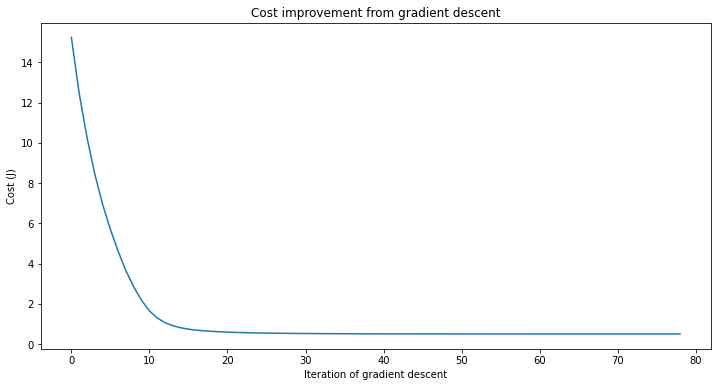

In [127]:
plt.plot(J_history_2)
plt.xlabel('Iteration of gradient descent')
plt.ylabel('Cost (J)')
plt.title('Cost improvement from gradient descent')
plt.show()

In [128]:
print(f'Best Cost: {J_2}')

Best Cost: [0.50321051]


In [135]:
score = ((h(x_validate_with_categoricals.to_numpy(), theta_tuned_2)>.5).astype(int)==y_validate.to_numpy()).mean()
print('Validation Accuracy: {:.1%}'.format(score))

Validation Accuracy: 79.2%


Woohoo!! The accuracy improved from 69.2% to 79.2% by including the categorical variables Sex, Embarked, and Class!

## Outliers
* Kinds of outliers
    * Point outliers (scatter plot)
    * contexual outliers (time series data)
    * collective outliers (missings data)
* Locating outliers
    * Box & Whisker Plot
    * fit exponential smoothing model, large errors are possible errors

## Missing values
* Discard rows with missing values
* Use categorical [0/1] variable to indicate missing data
* Estimate missing values (rule of thumb: do this for no more than 5% per feature)
    * impute with midrange value (mean, median, mode- for categorical)
    * Impute missing values with an algorithm using all other factors 
* build totally seperate models 
    * one for data with no missing values, one for data with missing values

## Feature Selection
* Manual selection
* Greedy methods (does what is best for right now)
    * Forward selection (start with no values, add best new feature)
    * Backward elimination (start with all factors, eliminate one at a time)
    * Stepwise regression (combination for forward and backward elimination)
    * Makes decision based on p-value (you choose the threshold) given by t-test: hypothesis is that the model is improved by adding(subtracting) the feature
* Newer methods (Globally optimized)
    * Lasso regression
    * Elastic Net
    * Difference between these is the regulatization term being with l1 or l2

# Get predictions for test data 
Don't forget to ...
* normalize features with mu, sigma from training data
* add intercept term
